<a href="https://colab.research.google.com/github/Meenusj/Case_study/blob/main/roberta_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[torch]
!pip install accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the dataset
file_path = "/content/combined_mutation_results (1).csv"  # Replace with the actual path
df = pd.read_csv(file_path)

# Preprocess the text data
def preprocess_text(text):
    return text.lower()

mutation_columns = ['char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
                    'word_mutated_articles', 'word_mutated_adjectives', 'word_mutated_adverbs']

for col in mutation_columns:
    df[col] = df[col].apply(preprocess_text)

# Concatenate mutation columns into one
df['mutations_combined'] = df[mutation_columns].apply(lambda x: ' '.join(x), axis=1)

# Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Shuffle the datasets
train_df = shuffle(train_df, random_state=42).reset_index(drop=True)
val_df = shuffle(val_df, random_state=42).reset_index(drop=True)
test_df = shuffle(test_df, random_state=42).reset_index(drop=True)

# Define file paths for saving the datasets
train_file = "train.csv"
val_file = "validation.csv"
test_file = "test.csv"

# Save the datasets to CSV files
train_df.to_csv(train_file, index=False)
val_df.to_csv(val_file, index=False)
test_df.to_csv(test_file, index=False)

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the text data
train_encodings = tokenizer(train_df['mutations_combined'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_df['mutations_combined'].tolist(), truncation=True, padding=True, max_length=128)

# Convert labels to numerical format
label_mapping = {'human': 0, 'bot': 1, 'rnn': 1, 'gpt2': 1, 'others': 1}
train_labels = train_df['class_type'].map(label_mapping).tolist()
val_labels = val_df['class_type'].map(label_mapping).tolist()

# Create PyTorch datasets
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = DetectionDataset(train_encodings, train_labels)
val_dataset = DetectionDataset(val_encodings, val_labels)

# Load the pre-trained RoBERTa model
roberta_base_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Define the training arguments for fine-tuning
training_args_finetune = TrainingArguments(
    output_dir="./roberta_finetuned_model",  # Adjust the output directory
    num_train_epochs=50,
    per_device_train_batch_size=32,  # Adjust batch size if needed
    per_device_eval_batch_size=32,    # Adjust batch size if needed
    logging_dir="./logs_finetune",
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    learning_rate=1e-4,
    load_best_model_at_end=True,
)
# Initialize the Trainer for fine-tuning
trainer_finetune = Trainer(
    model=roberta_base_model,
    args=training_args_finetune,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Assuming you already have val_dataset
    compute_metrics=lambda pred: {"accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1))},
)

# Train the model
trainer_finetune.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.494500,0.376922,0.809756


Step,Training Loss,Validation Loss,Accuracy
100,0.494500,0.376922,0.809756
200,0.278600,0.501691,0.829268
300,0.121500,0.711414,0.853659
400,0.125900,0.508021,0.887805
500,0.051500,0.670308,0.858537
600,0.037700,0.730863,0.863415
700,0.038000,0.656984,0.873171
800,0.022400,0.601238,0.873171
900,0.023200,0.578886,0.873171
1000,0.011300,0.765523,0.882927


TrainOutput(global_step=2900, training_loss=0.04409496559865837, metrics={'train_runtime': 2110.2626, 'train_samples_per_second': 43.62, 'train_steps_per_second': 1.374, 'total_flos': 6054843161472000.0, 'train_loss': 0.04409496559865837, 'epoch': 50.0})

In [3]:
import pandas as pd
test_df=pd.read_csv("/content/test.csv")

In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score
from tabulate import tabulate

def evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation_column, label_mapping):
    # Tokenize the test data for the specified mutation
    test_encodings = tokenizer(test_df[mutation_column].tolist(), truncation=True, padding=True, max_length=128)

    # Create PyTorch dataset for the specified mutation
    test_labels = test_df['class_type'].map(label_mapping).tolist()
    test_dataset = DetectionDataset(test_encodings, test_labels)

    # Evaluate on the specified mutation test set
    predictions = trainer_finetune.predict(test_dataset)

    # Get predicted labels and probabilities
    predicted_labels = predictions.predictions.argmax(-1)
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

    # Calculate accuracy and AUC for the specified mutation
    accuracy = accuracy_score(test_labels, predicted_labels)
    auc = roc_auc_score(test_labels, probs[:, 1])

    return accuracy, auc

# Evaluate each mutation separately including original text
mutations = ['original_text', 'char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
             'word_mutated_articles', 'word_mutated_adjectives', 'word_mutated_adverbs']

results = []
for mutation in mutations:
    mutation_accuracy, mutation_auc = evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation, label_mapping)
    if mutation == 'original_text':
        mutation = 'Human'
    results.append([mutation.capitalize(), mutation_accuracy, mutation_auc])

print("Roberta Finetune")
print(tabulate(results, headers=["Mutation", "Accuracy", "AUC"], tablefmt="fancy_grid"))


Roberta Finetune
╒═════════════════════════╤════════════╤══════════╕
│ Mutation                │   Accuracy │      AUC │
╞═════════════════════════╪════════════╪══════════╡
│ Human                   │   0.794922 │ 0.895282 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_article    │   0.806641 │ 0.874768 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_adjective  │   0.814453 │ 0.905915 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_adverb     │   0.814453 │ 0.905393 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_articles   │   0.792969 │ 0.880138 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_adjectives │   0.814453 │ 0.905531 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_adverbs    │   0.814453 │ 0.905102 │
╘═════════════════════════╧════════════╧══════════╛


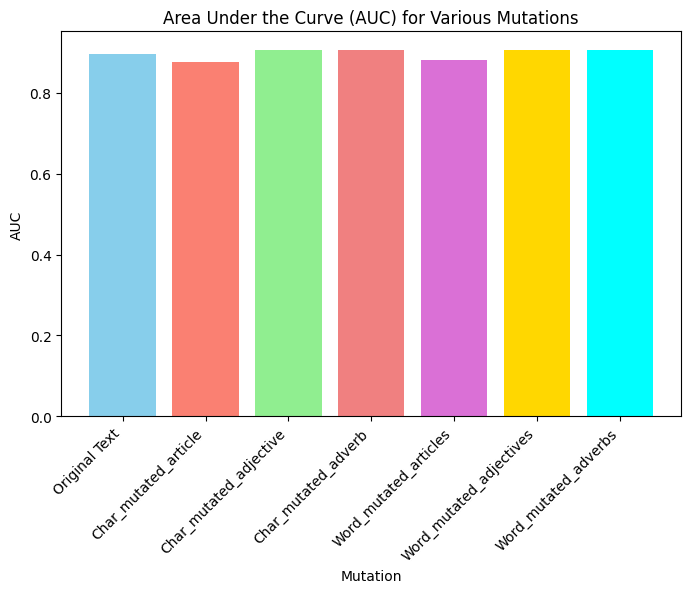

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation_column, label_mapping):
    # Tokenize the test data for the specified mutation
    test_encodings = tokenizer(test_df[mutation_column].tolist(), truncation=True, padding=True, max_length=128)

    # Create PyTorch dataset for the specified mutation
    test_labels = test_df['class_type'].map(label_mapping).tolist()
    test_dataset = DetectionDataset(test_encodings, test_labels)

    # Evaluate on the specified mutation test set
    predictions = trainer_finetune.predict(test_dataset)

    # Get predicted labels and probabilities
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

    # Calculate AUC for the specified mutation
    auc = roc_auc_score(test_labels, probs[:, 1])

    return auc

# Evaluate each mutation separately including original text
mutations = ['original_text', 'char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
             'word_mutated_articles', 'word_mutated_adjectives', 'word_mutated_adverbs']

auc_scores = []
mutation_labels = []
for mutation in mutations:
    mutation_auc = evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation, label_mapping)
    auc_scores.append(mutation_auc)
    if mutation == 'original_text':
        mutation_labels.append('Original Text')
    else:
        mutation_labels.append(mutation.capitalize())

# Define colors for each mutation
colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'orchid', 'gold', 'cyan']

# Plotting
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
plt.bar(np.arange(len(mutations)), auc_scores, color=colors)
plt.xlabel('Mutation')
plt.ylabel('AUC')
plt.title('Area Under the Curve (AUC) for Various Mutations')
plt.xticks(np.arange(len(mutations)), mutation_labels, rotation=45, ha='right')
plt.show()


In [9]:
import pandas as pd
test_df_article=pd.read_csv("/content/combined_mutation_results_article.csv")
test_df_article.columns

Index(['Unnamed: 0', 'article', 'class', 'original_text',
       'char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
       'Unnamed: 0.1', 'article.1', 'class.1', 'original_text.1',
       'char_mutated_article.1', 'char_mutated_adjective.1',
       'char_mutated_adverb.1', 'word_mutated_articles',
       'word_mutated_adjectives', 'word_mutated_adverbs'],
      dtype='object')

In [10]:
from sklearn.metrics import accuracy_score, roc_auc_score
from tabulate import tabulate

def evaluate_mutation(trainer_finetune, tokenizer, test_df_article, mutation_column, label_mapping):
    # Tokenize the test data for the specified mutation
    test_encodings = tokenizer(test_df_article[mutation_column].tolist(), truncation=True, padding=True, max_length=128)

    # Create PyTorch dataset for the specified mutation
    test_labels = test_df_article['class'].tolist()
    test_dataset = DetectionDataset(test_encodings, test_labels)

    # Evaluate on the specified mutation test set
    predictions = trainer_finetune.predict(test_dataset)

    # Get predicted labels and probabilities
    predicted_labels = predictions.predictions.argmax(-1)
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

    # Calculate accuracy and AUC for the specified mutation
    accuracy = accuracy_score(test_labels, predicted_labels)
    auc = roc_auc_score(test_labels, probs[:, 1])

    return accuracy, auc

# Evaluate each mutation separately including original text
mutations = ['original_text', 'char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
             'word_mutated_articles', 'word_mutated_adjectives', 'word_mutated_adverbs']

results = []
for mutation in mutations:
    mutation_accuracy, mutation_auc = evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation, label_mapping)
    if mutation == 'original_text':
        mutation = 'Human'
    results.append([mutation.capitalize(), mutation_accuracy, mutation_auc])

print("Roberta Finetune")
print(tabulate(results, headers=["Mutation", "Accuracy", "AUC"], tablefmt="fancy_grid"))


Roberta Finetune
╒═════════════════════════╤════════════╤══════════╕
│ Mutation                │   Accuracy │      AUC │
╞═════════════════════════╪════════════╪══════════╡
│ Human                   │   0.467583 │ 0.39824  │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_article    │   0.536346 │ 0.553709 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_adjective  │   0.484283 │ 0.436958 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_adverb     │   0.485265 │ 0.440546 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_articles   │   0.563851 │ 0.576227 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_adjectives │   0.466601 │ 0.397808 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_adverbs    │   0.467583 │ 0.3987   │
╘═════════════════════════╧════════════╧══════════╛


In [11]:
import pandas as pd
test_df_sentence=pd.read_csv("/content/combined_mutation_results_sentence.csv")
test_df_sentence.columns

Index(['Unnamed: 0', 'sentence', 'class', 'original_text',
       'char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
       'word_mutated_articles', 'word_mutated_adjectives',
       'word_mutated_adverbs', 'Unnamed: 0.1', 'sentence.1', 'class.1',
       'original_text.1', 'char_mutated_article.1', 'char_mutated_adjective.1',
       'char_mutated_adverb.1', 'word_mutated_articles.1',
       'word_mutated_adjectives.1', 'word_mutated_adverbs.1'],
      dtype='object')

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score
from tabulate import tabulate

def evaluate_mutation(trainer_finetune, tokenizer, test_df_sentence, mutation_column, label_mapping):
    # Tokenize the test data for the specified mutation
    test_encodings = tokenizer(test_df_sentence[mutation_column].tolist(), truncation=True, padding=True, max_length=128)

    # Create PyTorch dataset for the specified mutation
    test_labels = test_df_sentence['class'].tolist()
    test_dataset = DetectionDataset(test_encodings, test_labels)

    # Evaluate on the specified mutation test set
    predictions = trainer_finetune.predict(test_dataset)

    # Get predicted labels and probabilities
    predicted_labels = predictions.predictions.argmax(-1)
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

    # Calculate accuracy and AUC for the specified mutation
    accuracy = accuracy_score(test_labels, predicted_labels)
    auc = roc_auc_score(test_labels, probs[:, 1])

    return accuracy, auc

# Evaluate each mutation separately including original text
mutations = ['original_text', 'char_mutated_article', 'char_mutated_adjective', 'char_mutated_adverb',
             'word_mutated_articles', 'word_mutated_adjectives', 'word_mutated_adverbs']

results = []
for mutation in mutations:
    mutation_accuracy, mutation_auc = evaluate_mutation(trainer_finetune, tokenizer, test_df, mutation, label_mapping)
    if mutation == 'original_text':
        mutation = 'Human'
    results.append([mutation.capitalize(), mutation_accuracy, mutation_auc])

print("Roberta Finetune")
print(tabulate(results, headers=["Mutation", "Accuracy", "AUC"], tablefmt="fancy_grid"))


Roberta Finetune
╒═════════════════════════╤════════════╤══════════╕
│ Mutation                │   Accuracy │      AUC │
╞═════════════════════════╪════════════╪══════════╡
│ Human                   │   0.467583 │ 0.39824  │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_article    │   0.536346 │ 0.553709 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_adjective  │   0.484283 │ 0.436958 │
├─────────────────────────┼────────────┼──────────┤
│ Char_mutated_adverb     │   0.485265 │ 0.440546 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_articles   │   0.563851 │ 0.576227 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_adjectives │   0.466601 │ 0.397808 │
├─────────────────────────┼────────────┼──────────┤
│ Word_mutated_adverbs    │   0.467583 │ 0.3987   │
╘═════════════════════════╧════════════╧══════════╛
